In [1]:
import sys
sys.path.append('..')
import importlib
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as pyg
from tbparse import SummaryReader
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import os
from itertools import groupby
from collections import namedtuple
import math
import time
from PropLang import PropLang
import rejoice
from rejoice import EGraph
from rejoice.lib import Language
from rejoice.pretrain_dataset_gen import EGraphSolver

/home/ubuntu/anaconda3/envs/omelette/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-06-13 10:32:18.998397: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [ ]:
# !sudo apt install --yes cm-super dvipng texlive-fonts-recommended texlive-latex-extra texlive-latex-recommended

In [82]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'cm'
plt.rcParams['font.size'] = 18

plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200

# Limitations of Equality Saturation

In [110]:
def run_egg(lang: Language, expr, node_limit=10_000, iter_limit=7):
    print(f"running egg for expr", expr)
    first_stamp = int(round(time.time() * 1000))
    egraph = EGraph()
    egraph.add(expr)
    stop_reason, num_applications, num_enodes, num_eclasses = egraph.run(lang.rewrite_rules(), iter_limit=iter_limit, node_limit=node_limit)
    print(stop_reason, "num_applications", num_applications, "num_enodes", num_enodes, "num_eclasses", num_eclasses)
    best_cost, best_expr = egraph.extract(expr)
    second_stamp = int(round(time.time() * 1000))
    # Calculate the time taken in milliseconds
    time_taken = second_stamp - first_stamp
    # egraph.graphviz("egg_best.png")
    print(f"egg best cost:", best_cost, "in",
            f"{time_taken}ms", "best expr: ", best_expr)
    return best_cost

running egg for expr Or(x=And(x='x', y='y'), y=Implies(x='x', y='z'))
NODE_LIMIT num_applications 588 num_enodes 1133 num_eclasses 255
egg best cost: 5 in 3ms best expr:  Or(x='z', y=Implies(x='x', y='y'))
matched egg cost. Finding minimum sequence...
[0, 3, 4, 7, 8, 12, 2, 3, 4, 6, 7, 9, 11, 12, 2]
found best 5.0 Or(x='z', y=Implies(x='x', y='y')) [0, 4, 7, 8, 6, 7, 9, 11, 2, 13]
hit node limit when searching...


Text(0, 0.5, 'Node count')

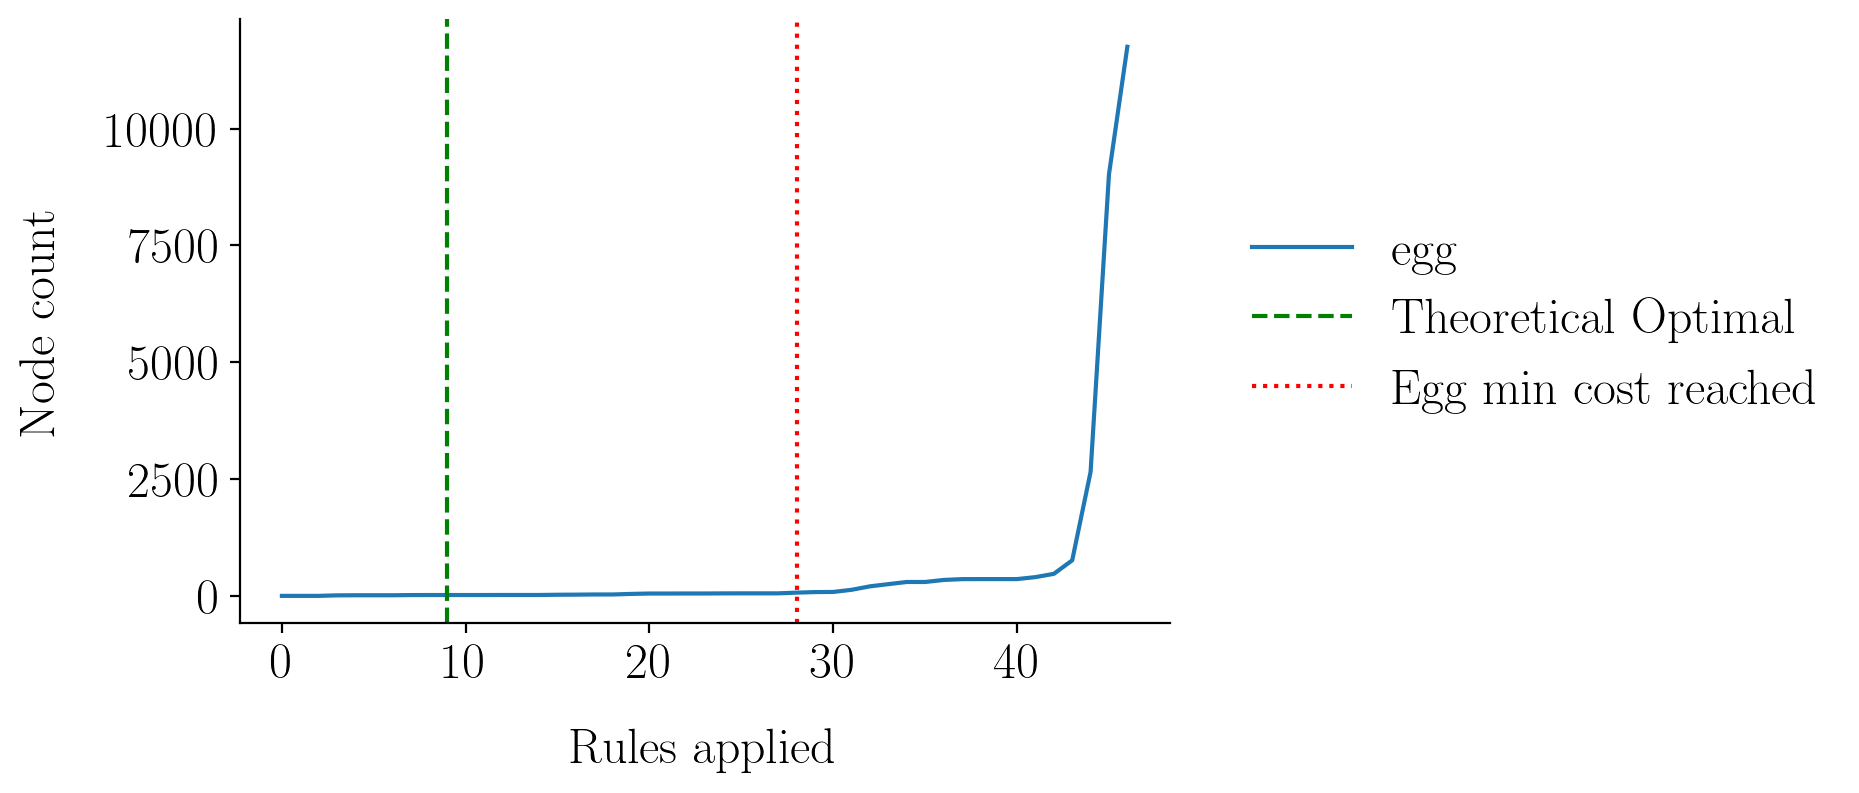

In [122]:
lang = PropLang()
ops = lang.all_operators_dict()
AND, NOT, OR, IM = ops["and"], ops["not"], ops["or"], ops["implies"]
x, y, z = "x", "y", "z"
expr = OR(AND(x, y), IM(x, z))
best_cost = run_egg(lang, expr, 1_000, 7)
solver = EGraphSolver(lang=lang, expr=expr, node_limit=1_000)
steps = solver.optimize(max_steps=10000)
df = pd.DataFrame(steps)
df["label"] = "optimal"
solver2 = EGraphSolver(lang=lang, expr=expr, node_limit=10_000)
steps2 = solver2.egg_like(max_steps=100_000)
df2 = pd.DataFrame(steps2)
df2["label"] = "egg"

best_cost_ind = df2["cost"].eq(best_cost).idxmax()

df3 = df2.reset_index()
ax = sns.lineplot(data=df3, x="index", y="num_enodes", hue="label")
sns.despine(top=True, right=True)
ax.xaxis.labelpad = 15
ax.yaxis.labelpad = 15

ax.axvline(len(df), linestyle='--', color='green', label="Theoretical Optimal")
ax.axvline(best_cost_ind, linestyle=':', color='red', label="Egg min cost reached")
leg = plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
leg.set_frame_on(False)
ax.set_xlabel("Rules applied")
ax.set_ylabel("Node count")




hit node limit when searching...


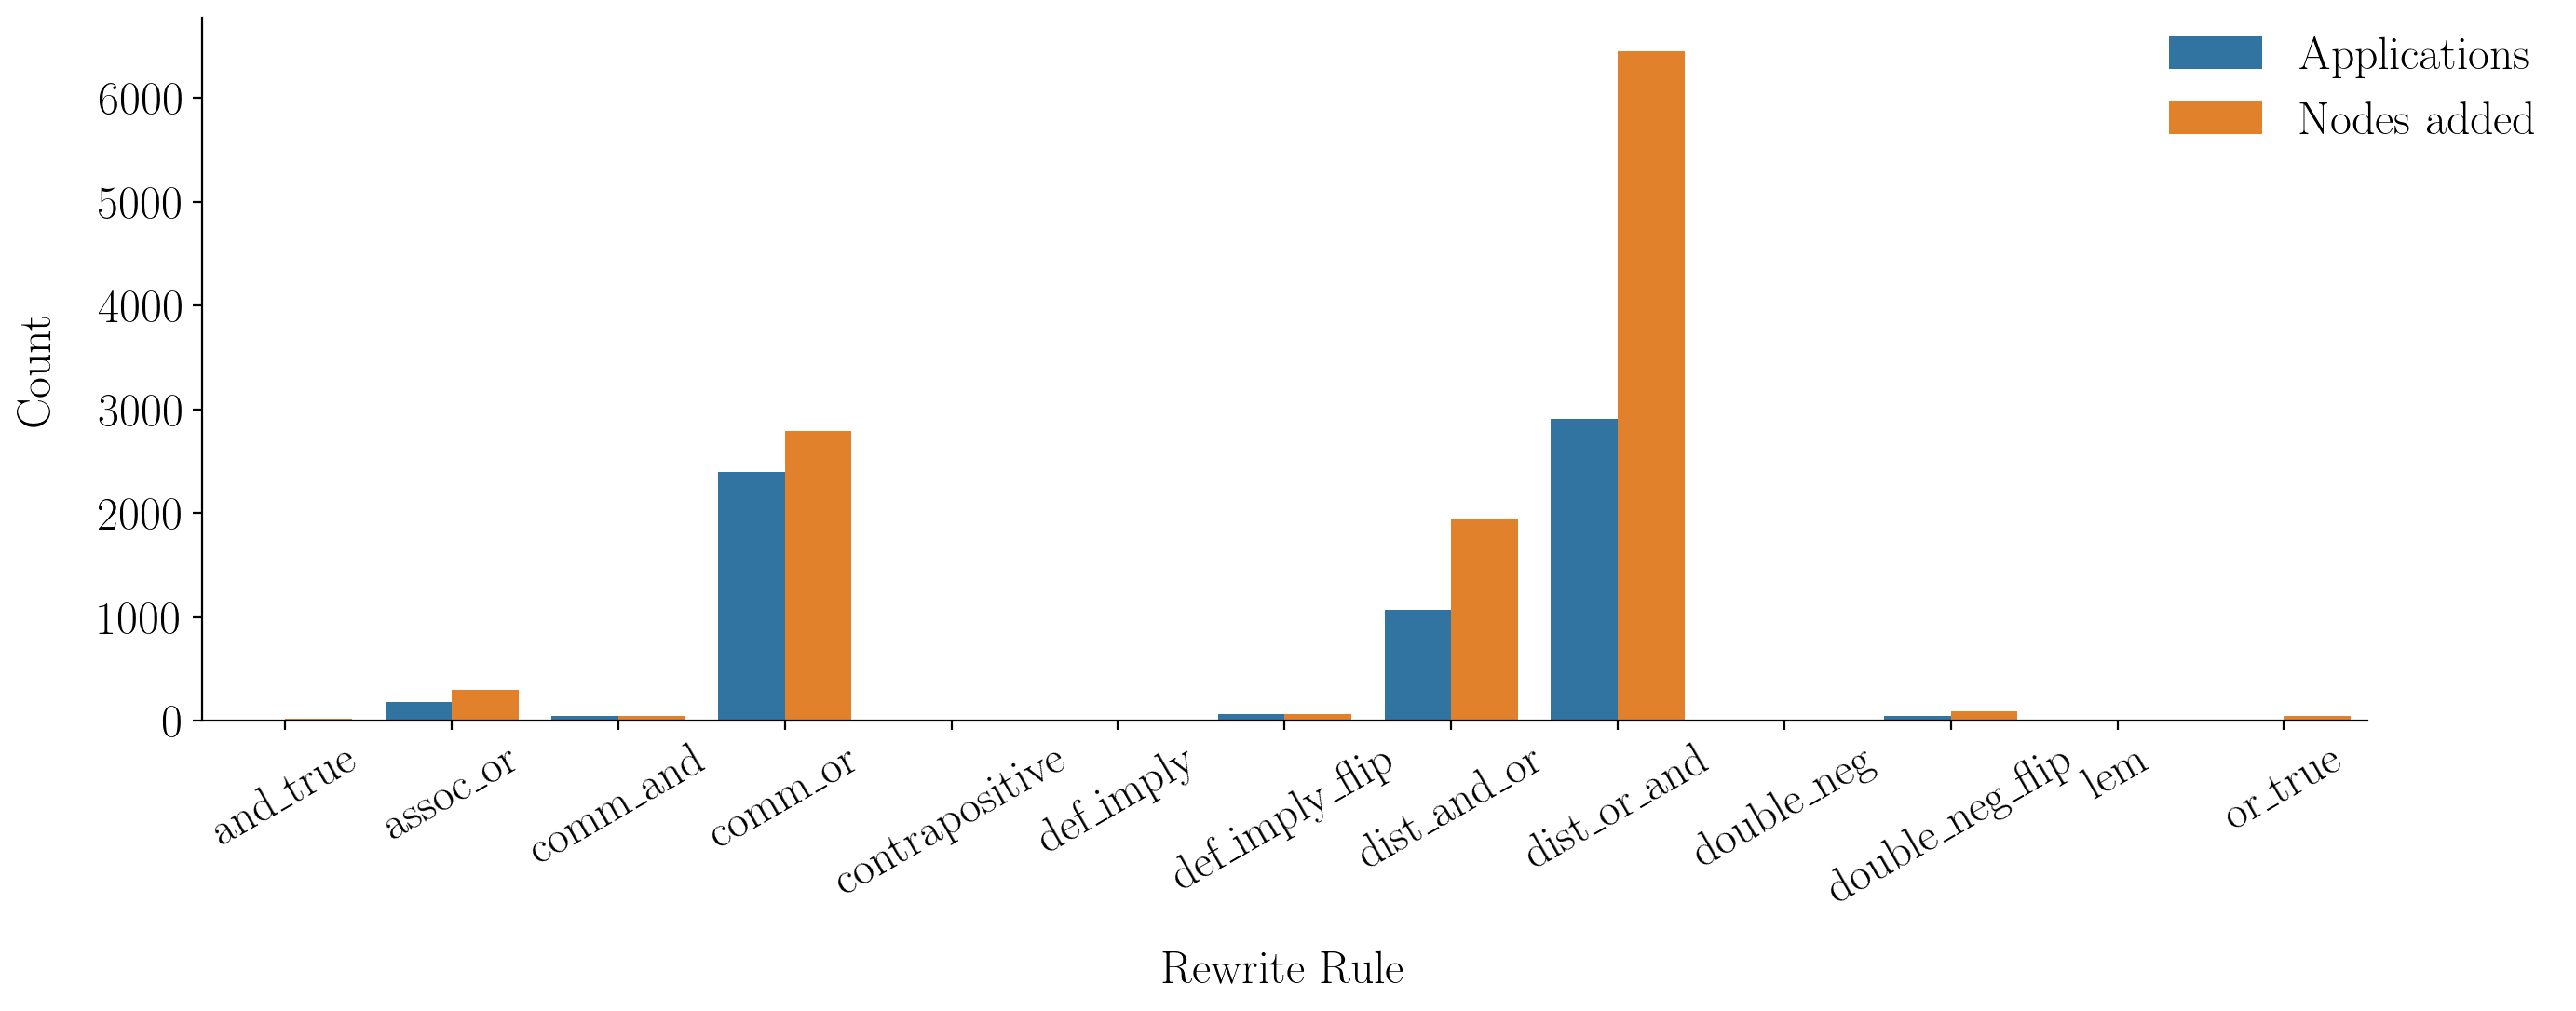

In [99]:
solver2 = EGraphSolver(lang=lang, expr=expr, node_limit=10_000)
steps2 = solver2.egg_like(max_steps=100_000)
df2 = pd.DataFrame(steps2)
df2["label"] = "egg"
df2["enodes_added"] = df2["num_enodes"].diff()
df2 = df2.groupby("action_name").agg('sum').reset_index()
df2 = df2[["action_name", "num_applications", "enodes_added"]]
df2 = df2.melt("action_name")
plt.rcParams['font.size'] = 18
plt.figure(figsize=(15, 5))
ax = sns.barplot(x="action_name", y="value", hue="variable", data=df2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
sns.despine(top=True, right=True)
ax.xaxis.labelpad = 15
ax.yaxis.labelpad = 15

ax.set_xlabel("Rewrite Rule")
ax.set_ylabel("Count")
plt.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0)
leg = ax.axes.get_legend()
leg.set_frame_on(False)

new_labels = ['Applications', 'Nodes added']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)

plt.savefig("sync/egg_limits_rules.pdf", bbox_inches='tight')

AttributeError: 'DataFrameGroupBy' object has no attribute 'groupby'

# Pretraining Graphs

### PROP

##### Dataset analysis

In [ ]:
def load_dataset(dataset_dir: str):
  files = os.listdir(dataset_dir)
  files.sort()
  keyf = lambda f: f.split("_")[0]

  files_grouped_by_expr = [list(expr_files) for gr, expr_files in groupby(files, key=keyf)]

  Row = namedtuple('Row', ['max_cost', 'min_cost', 'om_actions', 'egg_actions', 'action_mult', 'om_enodes', 'egg_enodes', 'enodes_mult', 'om_eclasses', 'egg_eclasses', 'eclasses_mult'])

  rows = []

  for group in files_grouped_by_expr:
    min_actions = len(group)
    d = torch.load(dataset_dir + "/" + group[-1])
    num_eclasses = int(torch.sum(d["x"][:, 0]).item())
    num_enodes = int(len(d["x"]) - num_eclasses)

    node_mult = (d.egg_enodes / num_enodes)
    class_mult = (d.egg_eclasses / num_eclasses)
    action_mult = (d.egg_rewrites / min_actions)

    rows.append(Row(max_cost=d.max_cost, min_cost=d.min_cost, om_actions=min_actions, egg_actions=d.egg_rewrites, action_mult=action_mult,
        om_enodes=num_enodes, egg_enodes=d.egg_enodes, enodes_mult=node_mult,
        om_eclasses=num_eclasses, egg_eclasses=d.egg_eclasses, eclasses_mult=class_mult))
    
  return pd.DataFrame(rows)

In [ ]:
df = load_dataset("../PropLang")
df = df[["action_mult", "enodes_mult", "eclasses_mult"]]
df_melted = pd.melt(df)
plt.figure(figsize = (15,8))
g = sns.boxplot(x='variable', y='value', data=df_melted)
g.set(ylabel="Multiplier", xlabel="Attribute", yscale="log")
plt.savefig("prop_data.pdf")

In [ ]:
df = load_dataset("../PropLang")
df = df[["min_cost", "max_cost"]]
df

##### Training/Test Accuracy Plots

In [ ]:
# Load log data
log_dir = "../lightning_logs/"
reader = SummaryReader(log_dir, extra_columns={'dir_name'})
df = reader.scalars
df_prop = df[df['dir_name'] == 'prop']
df_math = df[df['dir_name'] == 'math']


In [ ]:
def plot_acc(df, title):
  g = sns.lineplot(data=df, x='step', y='value')
  g.set(title=title, ylabel="Accuracy", xlabel="Step")
  return g

In [ ]:
def plot_acc_grid(df1, df2):
  df1 = df1.loc[df1['tag'].isin(['acc/train_acc', 'acc/val_acc'])]
  df2 = df2.loc[df2['tag'].isin(['acc/train_acc', 'acc/val_acc'])]
  df_all = pd.concat([df1, df2])

  g = sns.relplot(x="step", y="value", col="tag", row="dir_name", kind="line", data=df_all);
  g.set(ylabel="Accuracy", xlabel="Step")
  return g

g = plot_acc_grid(df_prop, df_math)
plt.savefig("sup_acc.pdf")

In [ ]:
train_acc_df = df[df['tag'] =='acc/train_acc']
plot_acc(train_acc_df, "Training Accuracy")

In [ ]:
al_acc_df = df[df['tag'] =='acc/val_acc']


# Single-Task Performance

# Generalizability